In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import os

import cv2

from zipfile import ZipFile



# 1. Unzip dataset.zip into the current working directory

with ZipFile("dataset.zip", 'r') as zip_ref:

    zip_ref.extractall()



# 2. Set dataset paths based on your structure

train_folder = "train"

test_folder = "test"

processed_data_path = "Processed_Data"



# 3. Create output directories if they don't exist

if not os.path.exists(processed_data_path):

    os.makedirs(processed_data_path)

    os.makedirs(os.path.join(processed_data_path, "train"))

    os.makedirs(os.path.join(processed_data_path, "test"))



IMG_SIZE = (224, 224)



# 4. Image preprocessing function

def preprocess_images(source_dir, target_dir, img_size=IMG_SIZE):

    emotions = os.listdir(source_dir)

    for emotion in emotions:

        emotion_path = os.path.join(source_dir, emotion)

        if not os.path.isdir(emotion_path):

            continue

        target_emotion_path = os.path.join(target_dir, emotion)

        if not os.path.exists(target_emotion_path):

            os.makedirs(target_emotion_path)

        for img_name in os.listdir(emotion_path):

            img_path = os.path.join(emotion_path, img_name)

            try:

                img = cv2.imread(img_path)

                if img is None:

                    continue

                img = cv2.resize(img, img_size)

                if len(img.shape) == 2:

                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                elif img.shape[2] == 4:

                    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

                elif img.shape[2] == 1:

                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                target_img_path = os.path.join(target_emotion_path, img_name)

                cv2.imwrite(target_img_path, img)

            except Exception as e:

                print(f"Error processing {img_path}: {e}")

                continue



# 5. Run preprocessing on train and test

if os.path.exists(train_folder):

    print("Preprocessing training images...")

    preprocess_images(train_folder, os.path.join(processed_data_path, "train"))

else:

    print("Training folder not found!")



if os.path.exists(test_folder):

    print("Preprocessing testing images...")

    preprocess_images(test_folder, os.path.join(processed_data_path, "test"))

else:

    print("Testing folder not found!")



print("Preprocessing completed!")

Preprocessing training images...
Preprocessing testing images...
Preprocessing completed!


Training dataset:
Emotions: ['fear', 'anger', 'Natural', 'joy']
fear: 39 images


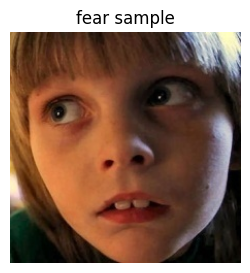

anger: 59 images


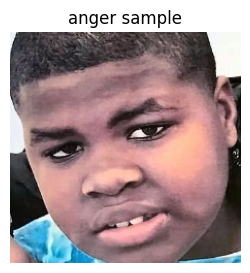

Natural: 147 images


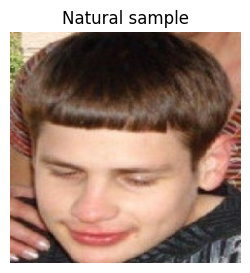

joy: 370 images


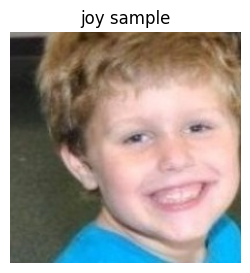


Testing dataset:
Emotions: ['fear', 'anger', 'Natural', 'joy']
fear: 10 images


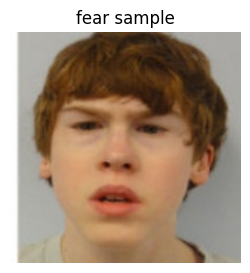

anger: 15 images


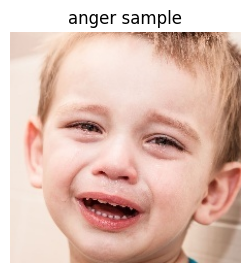

Natural: 37 images


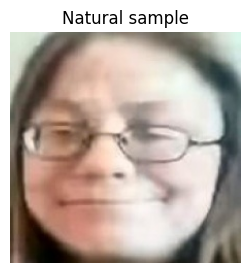

joy: 93 images


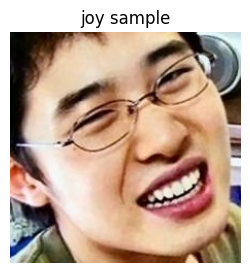

In [3]:
# Explore the processed dataset
def explore_dataset(dataset_path):
    emotions = os.listdir(dataset_path)
    print("Emotions:", emotions)

    for emotion in emotions:
        emotion_path = os.path.join(dataset_path, emotion)
        if os.path.isdir(emotion_path):
            num_images = len(os.listdir(emotion_path))
            print(f"{emotion}: {num_images} images")

            # Display sample image
            if num_images > 0:
                sample_img = os.listdir(emotion_path)[0]
                sample_img_path = os.path.join(emotion_path, sample_img)
                img = cv2.imread(sample_img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                plt.figure(figsize=(3, 3))
                plt.imshow(img)
                plt.title(f"{emotion} sample")
                plt.axis('off')
                plt.show()

print("Training dataset:")
explore_dataset(os.path.join(processed_data_path, "train"))

print("\nTesting dataset:")
explore_dataset(os.path.join(processed_data_path, "test"))


In [4]:
# Create data generators
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2  # Using 20% of training data for validation
)

# Only rescaling for validation and testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(processed_data_path, "train"),
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    os.path.join(processed_data_path, "train"),
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    os.path.join(processed_data_path, "test"),
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get class labels
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)
print("Number of classes:", len(class_labels))

Found 494 images belonging to 4 classes.
Found 121 images belonging to 4 classes.
Found 155 images belonging to 4 classes.
Class labels: ['Natural', 'anger', 'fear', 'joy']
Number of classes: 4


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# MobileNetV2 base model (pretrained on ImageNet)
mobileNet_base = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
mobileNet_base.trainable = False  # Freeze base layers

# Add custom classifier on top
inputs = Input(shape=(224, 224, 3))
x = mobileNet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

mobileNet_model = Model(inputs, outputs)
mobileNet_model.summary()

mobileNet_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = mobileNet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150
)

Found 615 images belonging to 4 classes.
Found 155 images belonging to 4 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,428,100 (9.26 MB)

 Trainable params: 167,300 (653.52 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.2789 - loss: 2.3301 - val_accuracy: 0.1548 - val_loss: 1.5276
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.3145 - loss: 2.0532 - val_accuracy: 0.3806 - val_loss: 1.3387
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - accuracy: 0.4006 - loss: 1.8362 - val_accuracy: 0.5484 - val_loss: 1.1508
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.4030 - loss: 1.7114 - val_accuracy: 0.5677 - val_loss: 1.0913
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - accuracy: 0.3852 - loss: 1.7528 - val_accuracy: 0.5742 - val_loss: 1.0621
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - accuracy: 0.4613 - loss: 1.5247 - val_accuracy: 0.6129 - val_loss: 1.0107
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.4774 - loss: 1.5108 - val_accuracy: 0.6323 - val_loss: 0.9298
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step - accuracy: 0.4632 - loss: 1.4162 - val_accura

Train Accuracy: 88.29%
Test Accuracy: 74.19%
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


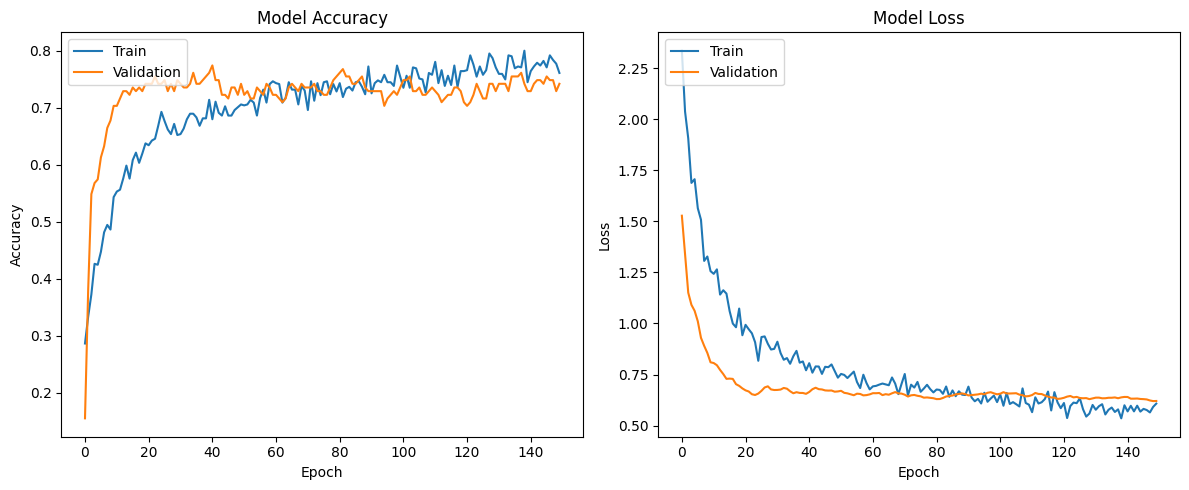

In [7]:
# Evaluate the model on test data
test_loss, test_accuracy = mobileNet_model.evaluate(test_generator, verbose=0)
train_loss, train_accuracy = mobileNet_model.evaluate(train_generator, verbose=0)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
test_generator.reset()
predictions = mobileNet_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 pretrained on ImageNet
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False  # Freeze the base layers

# Custom classifier
inputs = Input(shape=(224, 224, 3))
x = vgg_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

vgg_model = Model(inputs, outputs)
vgg_model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train VGG16 model
vgg_history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150
)

Found 615 images belonging to 4 classes.
Found 155 images belonging to 4 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2337 - loss: 2.3729 - val_accuracy: 0.1290 - val_loss: 1.3952
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - accuracy: 0.3411 - loss: 2.1564 - val_accuracy: 0.4323 - val_loss: 1.2878
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.3928 - loss: 1.8649 - val_accuracy: 0.6194 - val_loss: 1.1746
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.3997 - loss: 1.7584 - val_accuracy: 0.6387 - val_loss: 1.1171
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - accuracy: 0.4028 - loss: 1.7951 - val_accuracy: 0.6323 - val_loss: 1.0594
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 489ms/step - accuracy: 0.4986 - loss: 1.4468 - val_accuracy: 0.6323 - val_loss: 1.0178
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.5052 - loss: 1.4229 - va

Train Accuracy: 82.28%
Test Accuracy: 67.74%
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step


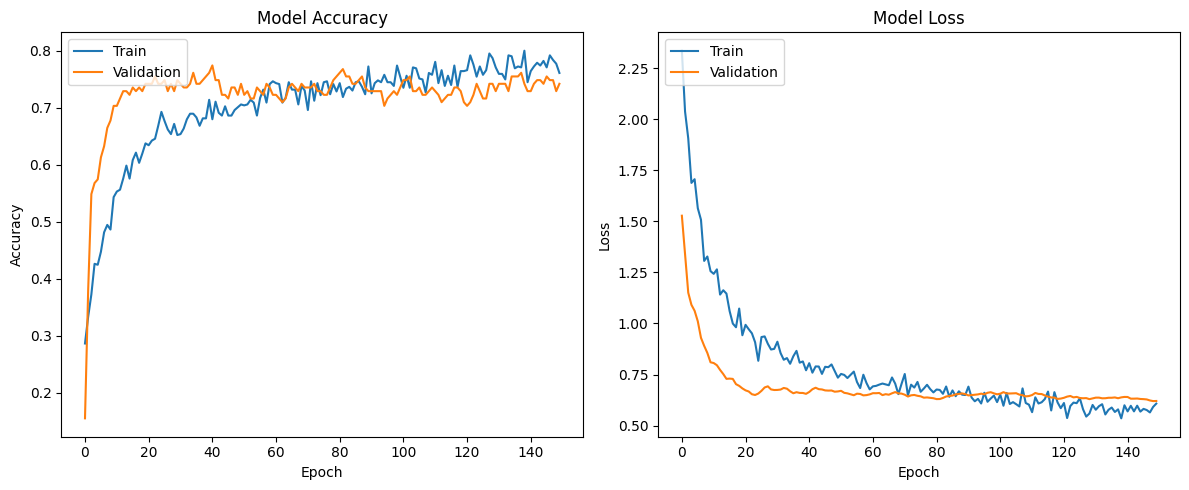

In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = vgg_model.evaluate(test_generator, verbose=0)
train_loss, train_accuracy = vgg_model.evaluate(train_generator, verbose=0)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
test_generator.reset()
predictions = vgg_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

VGG16 Validation Accuracy: 67.74%
MobileNetV2 Validation Accuracy: 74.19%


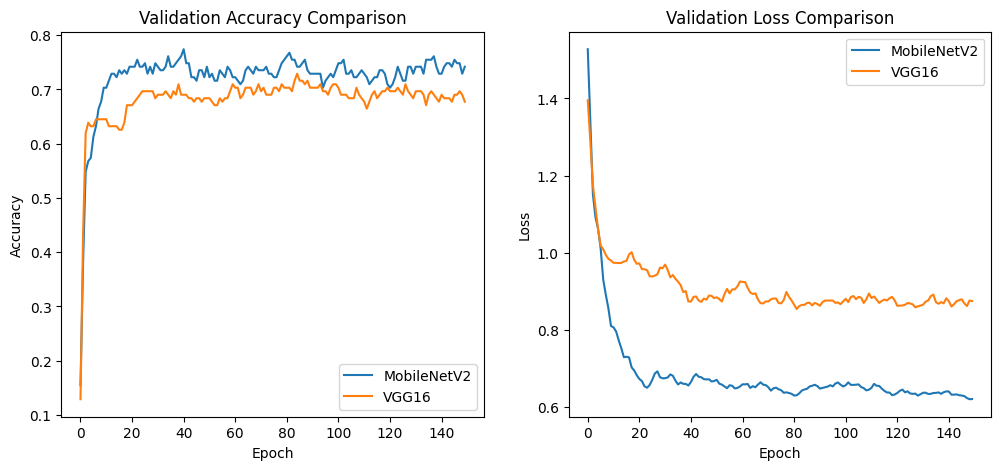

In [10]:
# Evaluate both models
vgg_eval = vgg_model.evaluate(val_generator, verbose=0)
mobilenet_eval = mobileNet_model.evaluate(val_generator, verbose=0)

print(f"VGG16 Validation Accuracy: {vgg_eval[1]*100:.2f}%")
print(f"MobileNetV2 Validation Accuracy: {mobilenet_eval[1]*100:.2f}%")

# Compare training history visually
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='MobileNetV2')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='MobileNetV2')
plt.plot(vgg_history.history['val_loss'], label='VGG16')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Cell: Predicting Emotion

import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_emotion(img_path, model, img_size=IMG_SIZE):
    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or cannot be read.")

    # Preprocess image: resize and convert to RGB
    img = cv2.resize(img, img_size)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    # Normalize pixel values
    img = img.astype('float32') / 255.0

    # Expand dimensions to fit model input shape
    img_batch = np.expand_dims(img, axis=0)  # Shape: (1, height, width, channels)

    # Predict
    preds = model.predict(img_batch)
    pred_class = np.argmax(preds, axis=1)[0]
    emotion_label = class_labels[pred_class]  # Use class_labels from notebook scope

    # Show result
    plt.imshow(img)
    plt.title(f"Predicted Emotion: {emotion_label}")
    plt.axis('off')
    plt.show()
    print(f"Predicted Emotion: {emotion_label}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


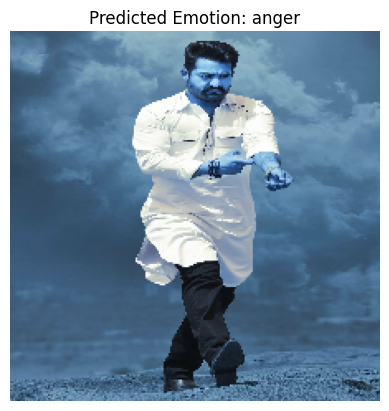

Predicted Emotion: anger


In [14]:
#Prediction 1
input_path_1 = 'Ntr.jpg'
predict_emotion(input_path_1, mobileNet_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


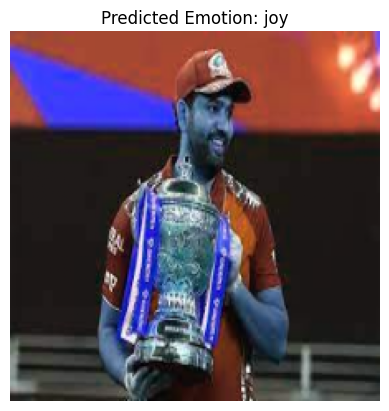

Predicted Emotion: joy


In [15]:
input_path_2 = 'Rohit.jpg'
predict_emotion(input_path_2, mobileNet_model)